In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
                            median_absolute_error, mean_absolute_percentage_error
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools

import warnings
warnings.filterwarnings("ignore")

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

def datatransform(data):
    data['Data'] = pd.to_datetime(data['Data'],dayfirst=True)
    data = data.sort_values('Data',ascending=True)
    data = data.groupby(pd.Grouper(key='Data', freq='1D')).mean()
    data = data.iloc[6: , :]  # seleziono i valori dal 08-09-2022
    for k in data.columns: 
        data[k].fillna(method='bfill',inplace=True)  # fill NaN with method bfill
    return data


In [2]:
data = pd.read_csv('dataframe.csv',parse_dates=['date'],index_col=['date'])
data

,perc_oggi,ospedalizzati_oggi,Temperatura_media,Umidità_media
date,,,,
2020-09-07,1.460000,268.0,20.981416,79.769909
2020-09-08,1.432857,275.0,21.696111,71.287302
2020-09-09,1.380000,279.0,22.247918,70.887285
2020-09-10,1.350000,286.0,22.795952,73.563690
2020-09-11,1.378571,273.0,23.065238,72.722619
...,...,...,...,...
2022-08-30,14.430000,680.0,24.902930,73.119505
2022-08-31,14.257143,655.0,23.088153,76.984631
2022-09-01,14.020000,627.0,23.094048,70.111264


In [ ]:
# "manual" loop in order to search the best combination of feature selection 

feat_extr_diz = {
    'dayofweek':data.index.dayofweek,
    'quarter':data.index.quarter,
    'day':data.index.day,
    'weekofyear':data.index.weekofyear,
    'month':data.index.month,
}


error = {}

stuff = feat_extr_diz.keys()
number = 1
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        print(f'\n________________\nnew subset training n {number}: ')
        data_loop = data.copy()
        for i in list(subset):    
            data_loop[i] = feat_extr_diz[i]
            
        print(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns))
        print()
        
        # perc shifted by 7 d in future
        data_loop.perc_oggi = data_loop.perc_oggi.shift(7).fillna(method='bfill')
        data_loop.Umidità_media = data_loop.Umidità_media.shift(7).fillna(method='bfill')
        data_loop.Temperatura_media = data_loop.Temperatura_media.shift(7).fillna(method='bfill')

        
        # y ospedalizzati
        series = data_loop.ospedalizzati_oggi

        # splitting test and train
        len_train_train_test = int(len(series.index)-len(series.index)*15/100)
        index_train_test = list(data_loop.index)[len_train_train_test]

        # y test and y train
        y_train = series[series.index <= index_train_test]
        y_test = series[series.index > index_train_test]

        # X exog df
        exog_col = list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)  
        exogen_train = data_loop[exog_col][data_loop.index <= index_train_test]
        exogen_test = data_loop[exog_col][data_loop.index > index_train_test]
        
        # prediction df after training
        df_exog_prediction = data_loop[exog_col][data_loop.index >= data_loop.index[-7]].reset_index(drop=True)
        df_exog_prediction['date'] = pd.date_range(start=exogen_test.index[-1]+timedelta(1),periods=7,freq='D')
        df_exog_prediction.set_index('date',inplace=True)
    
    
    
    
        # -> SARIMAX Model train/test
        sxmodel = pm.auto_arima(y_train.values.reshape(-1, 1), 
                                    exogenous = exogen_train.values.reshape(-1,len(exog_col)),
                                    start_p=1, start_q=1, d=None,
                                    max_p=5, max_q=5,
                                    start_P=0, start_Q=0, D=None,
                                    seasonal=True,
                                    m = 7,
                                    test='adf',
                                    n_jobs=-1,
                                    trace=False,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)


        # Forecast
        n_periods = len(y_test)
        fitted_values, confint = sxmodel.predict(n_periods=n_periods, 
                                              exogenous = exogen_test.values.reshape(-1,len(exog_col)), 
                                              return_conf_int=True)
        index_of_fc = pd.date_range(y_test.index[1], periods = n_periods, freq='D')
        fitted_series_test = pd.Series(fitted_values, index=index_of_fc)

        # Plot
        plt.figure(figsize=(8,6))
        plt.plot(y_test,label='test set')
        plt.plot(fitted_series_test, color='darkgreen',label='forecasting set')
        plt.legend()
        title = "Final Forecast SARIMAX - exog var: " + str(number)
        plt.title(title)
        plt.show()
        
        # error
        print(f'\nError on test SARIMAX - exog var: {number}:' + str(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)))
        calcError(y_test,fitted_series_test)

        RMSE = sqrt(mean_squared_error(y_test, fitted_series_test))
        MAPE = mean_absolute_percentage_error(y_test, fitted_series_test)
        
        error[number]= [round(RMSE,4),
                        str(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)),
                        round(MAPE,4)]
        
        number = number + 1
        print('_________________')
              


In [ ]:
# best model by rmse; 
result_error = pd.DataFrame(error.values(),index=error.keys())
result_error.rename(columns={0:'rmse',1:'features',2:'mape'},inplace=True)
pd.set_option('max_colwidth', 800)
result_error.sort_values(by='rmse',ascending=True)

,rmse,features,mape
28,165.3855,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']",0.1573
31,175.9998,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear', 'month']",0.1622
10,199.4328,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'month']",0.1641
32,231.1412,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear', 'month']",0.1610
18,246.3404,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear']",0.2837
6,250.2036,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'month']",0.2035
26,251.7046,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'weekofyear', 'month']",0.2609
16,262.8648,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear', 'month']",0.2240
29,286.8078,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear', 'month']",0.2582
19,312.2665,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'month']",0.2197


In [ ]:
# best model by mape
pd.set_option('max_colwidth', 800)
result_error.sort_values(by='mape',ascending=True)


,rmse,features,mape
28,165.3855,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']",0.1573
32,231.1412,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear', 'month']",0.1610
31,175.9998,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear', 'month']",0.1622
10,199.4328,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'month']",0.1641
6,250.2036,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'month']",0.2035
19,312.2665,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'month']",0.2197
16,262.8648,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear', 'month']",0.2240
27,350.0939,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear']",0.2255
12,356.7813,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'weekofyear']",0.2307
11,348.9706,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day']",0.2315


In [4]:
# -> best model rmse: ['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']
# -> best model mape: ['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']

def timeserieFeatureExtractor_best(timeseries):
    timeseries['dayofweek'] = timeseries.index.dayofweek
    timeseries['quarter'] = timeseries.index.quarter
    timeseries['day'] = timeseries.index.day
    timeseries['month'] = timeseries.index.month
    timeseries.fillna(0,inplace=True)
    return 

data = data[data.index <= '2022-09-03']

# y series
series = pd.DataFrame(data.ospedalizzati_oggi)

# exogen series 
exog_series = data.drop('ospedalizzati_oggi',axis=1)

# feature extraction
timeserieFeatureExtractor_best(exog_series)

# exogen series (prediction)
exog_df_prediction = pd.DataFrame(exog_series[exog_series.index >= exog_series.index[-7]])

# perc shifted by 7 d in future
exog_series.perc_oggi = exog_series.perc_oggi.shift(7).fillna(method='bfill')
exog_series.Umidità_media = exog_series.Umidità_media.shift(7).fillna(method='bfill')
exog_series.Temperatura_media = exog_series.Temperatura_media.shift(7).fillna(method='bfill')


In [5]:
# -> SARIMAX Model on all ts
sxmodel_all = pm.auto_arima(series.values.reshape(-1, 1), 
                                    exogenous = exog_series.values.reshape(-1,len(exog_series.columns)),
                                    start_p=1, start_q=1, d=None,
                                    max_p=5, max_q=5,
                                    start_P=0, start_Q=0, D=None,
                                    seasonal=True,
                                    m = 7,
                                    test='adf',
                                    n_jobs=-1,
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=7808.373, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8435.554, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7829.662, Time=1.73 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8078.690, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8433.965, Time=0.49 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=7721.435, Time=1.77 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=7731.035, Time=2.81 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=7761.394, Time=2.53 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=7927.411, Time=1.72 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=7787.443, Time=2.13 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=7797.836, Time=2.16 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=8014.976, Time=1.66 sec
 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=7

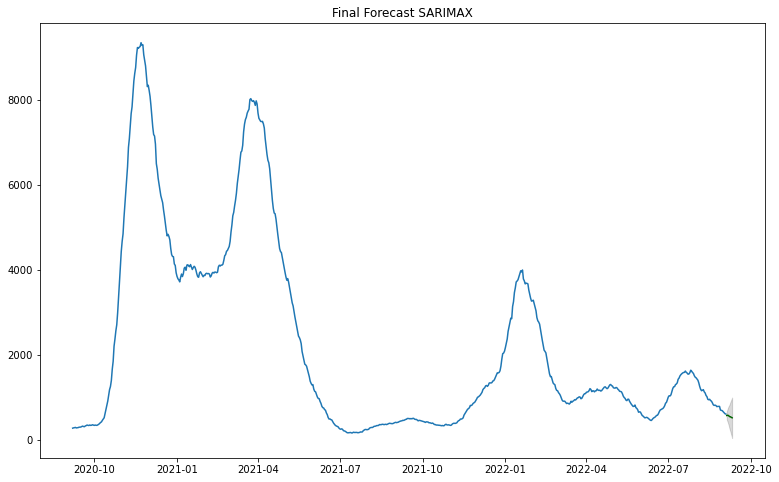

In [6]:
# Forecast
n_periods = 7
fitted_values, confint = sxmodel_all.predict(n_periods=n_periods, 
                                  exogenous=exog_df_prediction.values.reshape(-1,len(exog_df_prediction.columns)), 
                                  return_conf_int=True)



index_of_fc = pd.date_range(series.index[-1]+timedelta(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted_values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(13,8))
plt.plot(series)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast SARIMAX")
plt.show()

In [7]:
# df prediction of sarimax trained on all data
fitted_series

2022-09-04    566.617089
2022-09-05    570.660029
2022-09-06    565.309277
2022-09-07    540.864053
2022-09-08    536.192977
2022-09-09    523.843423
2022-09-10    511.934037
Freq: D, dtype: float64

In [10]:
with open("results.txt","a") as res:
    res.write('SARIMAX - temp/hum\n')
    for i in range(len(fitted_series)):
        date = str(fitted_series.index[i])
        value = str(round(fitted_series.values[i],4))
        res.write(date+' - '+value+'\n')
    res.write('\n\n')